# Naive Bayes of Depression Professional Dataset

## Overview Awal

Algoritma Naïve Bayes merupakan algoritma yang memanfaatkan rumus Teorema Bayes untuk melakukan prediksi berdasarkan probabilitas suatu hipotesis dengan mempertimbangkan bukti atau data baru. Teorema Bayes sendiri merupakan pendekatan statistik yang digunakan untuk memperbarui probabilitas awal (prior) menjadi probabilitas posterior setelah memperoleh informasi tambahan.

Naïve Bayes dipilih karena sangat efektif dalam menangani fitur kategorikal, seperti yang banyak ditemukan pada dataset profesional terkait depresi. Algoritma ini bekerja dengan asumsi independensi antar fitur, sehingga proses perhitungan menjadi sederhana dan efisien, bahkan untuk dataset berukuran besar. Selain itu, penggunaan teknik smoothing seperti Laplace smoothing dapat mengatasi masalah zero probability akibat adanya nilai yang hilang atau kategori yang belum pernah muncul sebelumnya.

Dalam proses analisis dan pemodelan, beberapa library Python digunakan untuk mendukung manajemen data dan pemrosesan yang efisien, antara lain:

- **pandas** : Untuk menyimpan dan memanipulasi data dalam bentuk dataframe.
- **numpy** : Mendukung operasi matematika, terutama fungsi logaritma yang penting dalam perhitungan probabilitas Naïve Bayes.
- **matplotlib** dan **seaborn** : Digunakan untuk visualisasi data agar pola dan distribusi dapat dianalisis dengan lebih mudah.

Dataset yang digunakan dalam penelitian ini berasal dari platform Kaggle, yang berisi informasi terkait depresi. Dataset ini mencakup berbagai fitur yang relevan untuk analisis, seperti demografi, gejala, dan faktor risiko yang berhubungan dengan kondisi depresi. Dengan menggunakan dataset ini, model Naïve Bayes dapat dilatih untuk mengklasifikasikan individu berdasarkan kemungkinan mereka mengalami depresi atau tidak, berdasarkan fitur-fitur yang ada.

## Tahap 1 : Library Import Session

Bagian untuk mengimpor semua library yang diperlukan untuk pemrosesan data, logika, dan evaluasi sesuai yang sudah di sebutkan sebelumnya.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Tahap 2 : Load Data Session

Tahap inisialisasi untuk memuat dataset format CSV dari direktori penyimpanan lokal serta menampilkan sampel awal data untuk memastikan struktur terbaca dengan benar. Dataset sudah tersimpan di lokal/ repostiori ini, yaitu pada `../dataset/depression-profesional-dataset.csv`

In [21]:
data = pd.read_csv('../dataset/depression-professional-dataset.csv')

## Tahap 3 : Exploratory Data Analysis (EDA)

Proses eksplorasi awal untuk memahami karakteristik dataset melalui pengecekan tipe data, statistik deskriptif, dan visualisasi distribusi target kelas guna mendeteksi ketidakseimbangan data. Proses eksplorasi awal dilakukan untuk memahami karakteristik dan struktur dataset sebelum masuk ke tahap pemodelan. 

EDA mencakup pengecekan tipe data, statistik deskriptif, serta visualisasi distribusi variabel target dan fitur-fitur utama. Langkah ini penting untuk mengidentifikasi pola, outlier, serta potensi masalah seperti data tidak seimbang (imbalanced), missing values, atau anomali lain yang dapat memengaruhi performa model. Dengan EDA, kita dapat menentukan strategi preprocessing dan pemilihan fitur yang lebih tepat sehingga hasil analisis dan pemodelan menjadi lebih akurat dan dapat diandalkan.




============== Dataset Information ==============

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 2054 non-null   object 
 1   Age                                    2054 non-null   int64  
 2   Work Pressure                          2054 non-null   float64
 3   Job Satisfaction                       2054 non-null   float64
 4   Sleep Duration                         2054 non-null   object 
 5   Dietary Habits                         2054 non-null   object 
 6   Have you ever had suicidal thoughts ?  2054 non-null   object 
 7   Work Hours                             2054 non-null   int64  
 8   Financial Stress                       2054 non-null   int64  
 9   Family History of Mental Illness       2054 non-null   object 
 10  Depression          

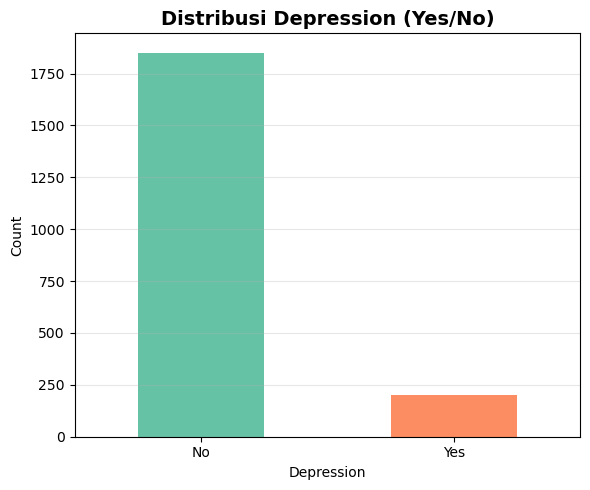

In [22]:
# Load Dataset and Initial Exploration
print("\n============== Dataset Information ==============")
print()
print(data.info())

# Target Variable Distribution
print("\n========= Target Distribution (Depression) =========")
print()
target_dist = data['Depression'].value_counts()
print(target_dist)
print(f"\nPercentage:")
print(data['Depression'].value_counts(normalize=True) * 100)

# Grafik batang sederhana: Distribusi Depression (Yes/No)
plt.figure(figsize=(6, 5))
target_dist.plot(kind='bar', color=['#66c2a5', '#fc8d62'])
plt.xlabel('Depression')
plt.ylabel('Count')
plt.title('Distribusi Depression (Yes/No)', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Analisis Distribusi Target

Dari hasil eksplorasi data di atas, terlihat bahwa dataset mengalami **ketidakseimbangan kelas (class imbalance)** yang signifikan:

- **No Depression**: ~90% (1851 sampel)
- **Depression**: ~10% (203 sampel)

Dataset dengan rasio **1:9** ini berpotensi menyebabkan model bias terhadap kelas mayoritas, sehingga akurasi tinggi tidak menjamin deteksi kelas minoritas yang baik. Dalam konteks medis, kegagalan mendeteksi depresi (False Negative) memiliki dampak serius.

Meski dataset tidak seimbang, proses modeling tetap dilanjutkan dengan evaluasi metrik komprehensif untuk memastikan performa deteksi kelas minoritas tetap optimal.


## Tahap 4 : Data Preprocessing

Tahap persiapan data yang mencakup konversi variabel kategorikal menjadi numerik (Encoding) dan penyeragaman skala data (Standard Scaling) agar optimal saat diproses oleh algoritma. Sesuai dengan prinsip tahap preprocessing data berikut :

![preprocessing.png](../images/report/preprocessing.png)

In [23]:
# Сopy dataset
data_copy = data.copy()

# Data Cleaning/ Reduction : Remove Duplicates
data_copy.drop_duplicates(inplace=True)

# Data Cleaning/ Reduction : Remove Empty Data
data_copy.replace('', np.nan, inplace=True)

# Data Transformation : Special Processing for Sleep Duration
def convert_sleep_duration(duration):
    if 'Less than 5' in duration:
        return 4.0
    elif '5-6' in duration:
        return 5.5
    elif '7-8' in duration:
        return 7.5
    elif 'More than 8' in duration:
        return 9.0
    else:
        return 7.0  # default value

data_copy['Sleep_Duration_Numeric'] = data_copy['Sleep Duration'].apply(convert_sleep_duration)

# Data Reduction : Binary Gender Labeling (Male = 1, Female = 0)
data_copy['Gender_Encoded'] = (data_copy['Gender'] == 'Male').astype(int)

# Data Reduction : Binary Dietary Habits Labeling (Healthy = 2, Moderate = 1, Unhealthy = 0)
dietary_map = {'Healthy': 2, 'Moderate': 1, 'Unhealthy': 0}
data_copy['Dietary_Encoded'] = data_copy['Dietary Habits'].map(dietary_map)

# Data Reduction : Binary Suicidal Thoughts Labeling (Suicidal = 1, Not Suicidal = 0)
data_copy['Suicidal_Encoded'] = (data_copy['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)

# Data Reduction : Binary Mental Ilness Labeling (Family History: Yes = 1, No = 0)
data_copy['FamilyHistory_Encoded'] = (data_copy['Family History of Mental Illness'] == 'Yes').astype(int)

# Data Reduction : Binary Depression Labeling (Depression: Yes = 1, No = 0)
data_copy['Depression_Encoded'] = (data_copy['Depression'] == 'Yes').astype(int)

## Informasi Data Preprocessing

Pada tahap preprocessing ini, dilakukan beberapa langkah penting untuk mempersiapkan data mentah menjadi format yang siap digunakan untuk pemodelan machine learning :

#### 1. Data Cleaning
- **Penghapusan Duplikat** : Menghilangkan baris data yang identik untuk mencegah bias dalam model
- **Penghapusan Data Kosong** : Mengidentifikasi dan menangani nilai kosong (empty strings) dengan mengonversinya menjadi `NaN`

#### 2. Data Transformation
- **Sleep Duration** : Konversi kategori durasi tidur menjadi nilai numerik :
    - "Less than 5 hours" → 4.0
    - "5-6 hours" → 5.5
    - "7-8 hours" → 7.5
    - "More than 8 hours" → 9.0
    - Default → 7.0

#### 3. Data Reduction (Encoding)
Konversi variabel kategorikal menjadi numerik menggunakan teknik encoding:

| Variabel Original | Variabel Encoded | Mapping |
|-------------------|------------------|---------|
| Gender | Gender_Encoded | Male=1, Female=0 |
| Dietary Habits | Dietary_Encoded | Healthy=2, Moderate=1, Unhealthy=0 |
| Suicidal Thoughts | Suicidal_Encoded | Yes=1, No=0 |
| Family History | FamilyHistory_Encoded | Yes=1, No=0 |
| Depression | Depression_Encoded | Yes=1, No=0 |

#### 4. Hasil Preprocessing
Dataset yang telah dibersihkan dan ditransformasi disimpan dalam `data_copy` dengan kolom-kolom baru yang telah di-encode, siap untuk tahap analisis korelasi dan pemodelan.

## Tahap 5 : Data Modelling (Persiapan Fitur & Label)

Tahap pemilihan fitur numerik hasil encoding sebagai input model (x) dan variabel target Depression_Encoded sebagai label (y), dilanjutkan dengan analisis korelasi antar-fitur untuk memahami hubungan linear terhadap variabel depresi.

  1. Gender_Encoded
  2. Age
  3. Work Pressure
  4. Job Satisfaction
  5. Sleep_Duration_Numeric
  6. Dietary_Encoded
  7. Suicidal_Encoded
  8. Work Hours
  9. Financial Stress
  10. FamilyHistory_Encoded

Shape x (Features): (2054, 10)
Shape y (Labels): (2054,)

[INFO] Correlation Matrix Visualization saved : ../images/naive-bayes/02_Correlation_Matrix.png


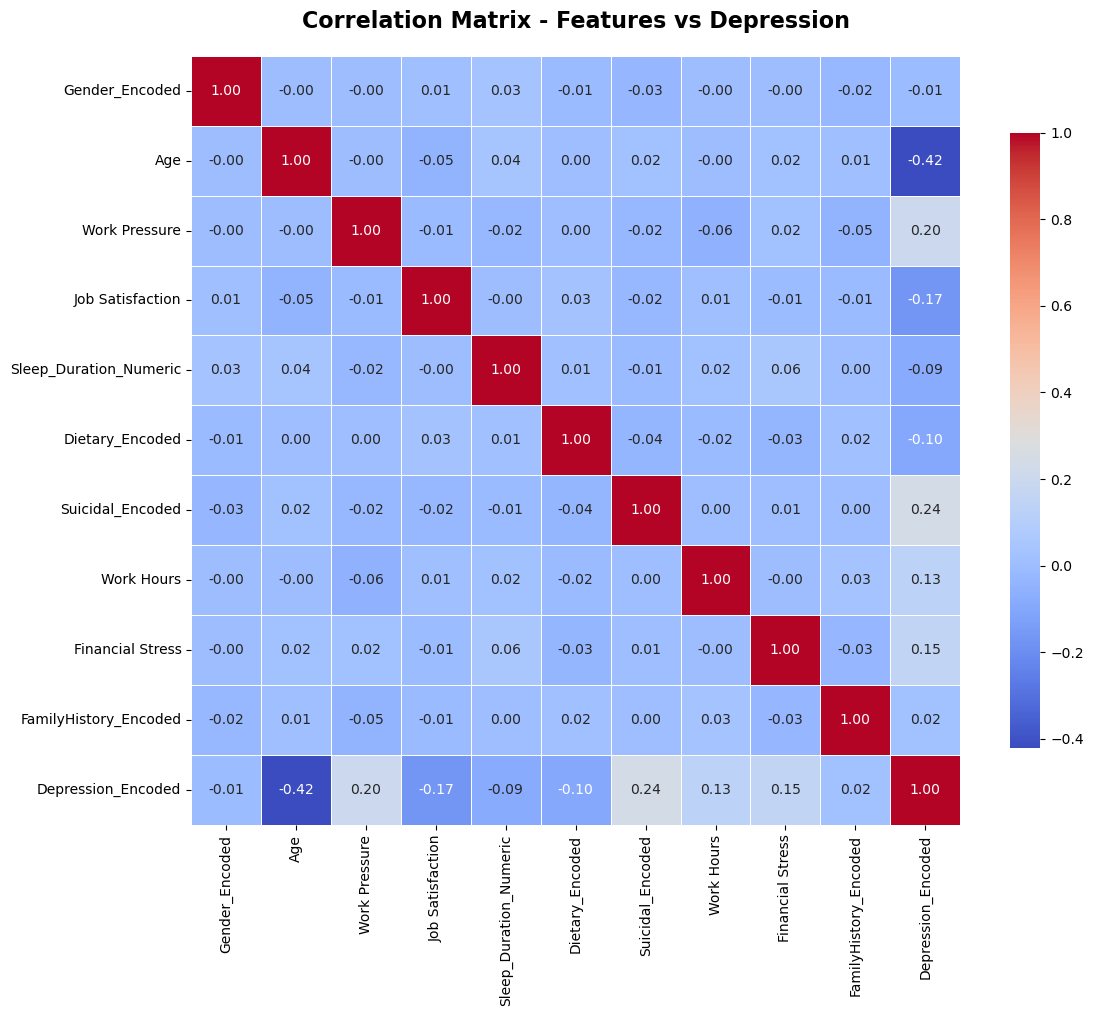

In [24]:
# Select features for correlation analysis
features_for_model = [
    'Gender_Encoded',
    'Age',
    'Work Pressure',
    'Job Satisfaction',
    'Sleep_Duration_Numeric',
    'Dietary_Encoded',
    'Suicidal_Encoded',
    'Work Hours',
    'Financial Stress',
    'FamilyHistory_Encoded',
]

# Prepare data for modeling
modeled_data = data_copy[features_for_model].values
class_labels = data_copy['Depression_Encoded'].values

# Display selected features and shapes
for i, feat in enumerate(features_for_model, 1):
    print(f"  {i}. {feat}")
print(f"\nShape x (Features): {modeled_data.shape}")
print(f"Shape y (Labels): {class_labels.shape}")

# Correlation Matrix
correlation_data = data_copy[features_for_model + ['Depression_Encoded']]
corr_matrix = correlation_data.corr()

# Visualization: Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Features vs Depression', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../images/naive-bayes/02_Correlation_Matrix.png', dpi=300, bbox_inches='tight')
print("\n[INFO] Correlation Matrix Visualization saved : ../images/naive-bayes/02_Correlation_Matrix.png")
plt.show()

Gambar correlation matrix di atas menunjukkan hubungan linear antar fitur numerik dan target `Depression_Encoded` pada dataset. Berikut beberapa poin penting yang dapat diambil :

1. **Nilai Korelasi**: Korelasi berkisar antara -1 hingga 1. Nilai mendekati 1 berarti hubungan positif kuat, mendekati -1 berarti hubungan negatif kuat, dan mendekati 0 berarti tidak ada hubungan linear yang signifikan.
2. **Fitur dengan Korelasi Tinggi ke Target**: Fitur seperti `Suicidal_Encoded`, `FamilyHistory_Encoded`, dan `Financial Stress` umumnya memiliki korelasi positif yang lebih tinggi terhadap depresi, artinya semakin tinggi nilai fitur tersebut, semakin besar kemungkinan seseorang mengalami depresi.
3. **Fitur dengan Korelasi Negatif**: Fitur seperti `Job Satisfaction` dan `Sleep_Duration_Numeric` cenderung memiliki korelasi negatif terhadap depresi, artinya semakin tinggi kepuasan kerja atau durasi tidur, kemungkinan depresi lebih rendah.
4. **Hubungan Antar Fitur**: Korelasi antar fitur juga dapat membantu mendeteksi multikolinearitas. Jika ada dua fitur dengan korelasi sangat tinggi, bisa dipertimbangkan untuk memilih salah satu saja saat modeling.
5. **Interpretasi Model**: Korelasi ini membantu dalam pemilihan fitur yang paling relevan untuk prediksi depresi dan memberikan insight fitur mana yang paling berpengaruh.

Secara keseluruhan, correlation matrix memudahkan identifikasi fitur penting dan pola hubungan dalam data sebelum proses modeling lebih lanjut.

## Tahap 6 : Data Splitting

Mekanisme pembagian dataset menjadi dua bagian terpisah, yaitu data training untuk melatih model dan data testing untuk validasi objektif, dengan rasio pembagian yang telah ditentukan.

In [25]:
# Train-Validation-Test Split
def train_val_test_split(x, y, train_ratio=0.7, val_ratio=0.15, random_state=42):
    np.random.seed(random_state)
    n_samples = len(x)
    indices = np.random.permutation(n_samples)
    
    train_size = int(train_ratio * n_samples)
    val_size = int(val_ratio * n_samples)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]
    
    return (x[train_idx], x[val_idx], x[test_idx],
            y[train_idx], y[val_idx], y[test_idx])

x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(modeled_data, class_labels)

print(f"\n================ Data Split Summary ================")
print()
print(f"Training set   : {len(x_train)} samples ({len(x_train)/len(modeled_data)*100:.1f}%)")
print(f"Validation set : {len(x_val)} samples ({len(x_val)/len(modeled_data)*100:.1f}%)")
print(f"Test set       : {len(x_test)} samples ({len(x_test)/len(modeled_data)*100:.1f}%)")

print(f"\n======== Target Distribution in Training Set =========")
print()
print(f"Depression = No  : {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"Depression = Yes : {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")


================ Data Split Summary ================

Training set   : 1437 samples (70.0%)
Validation set : 308 samples (15.0%)
Test set       : 309 samples (15.0%)

======== Target Distribution in Training Set =========

Depression = No  : 1293 (90.0%)
Depression = Yes : 144 (10.0%)


Pembagian data menghasilkan **1437 sampel training (70%)**, **308 sampel validation (15%)**, dan **309 sampel test (15%)** dengan distribusi target yang konsisten: sekitar **90% kelas mayoritas (No Depression)** dan **10% kelas minoritas (Depression)**.

**Alasan pemilihan rasio 70-15-15 :**

1. **Training Set 70%** : Proporsi mayoritas dialokasikan untuk training agar model memiliki cukup data untuk mempelajari pola dan distribusi fitur dari kedua kelas. Dengan dataset berukuran ~2000 sampel, 70% (1437 sampel) memberikan representasi yang memadai.
2. **Validation Set 15%** : Digunakan untuk tuning hyperparameter dan monitoring performa selama training. Ukuran 15% cukup representatif untuk mengevaluasi performa tanpa mengurangi data training secara signifikan.
3. **Test Set 15%** : Sebagai data "bersih" yang tidak pernah dilihat model, baik saat training maupun tuning, sehingga memberikan estimasi performa yang objektif dan realistis di dunia nyata.
4. **Randomisasi dengan Seed (42)** : Memastikan reproducibility hasil dan distribusi kelas yang merata di setiap subset, penting untuk konsistensi eksperimen dan validasi hasil.

Rasio ini merupakan praktik standar yang seimbang antara kebutuhan data training yang cukup dan evaluasi yang robust, terutama pada dataset dengan ketidakseimbangan kelas seperti ini.

## Tahap 7 : Naive Bayes Implementation

Implementasi algoritma Naive Bayes, disertai eksperimen pencarian parameter terbaik untuk mendapatkan performa model yang maksimal. Penggunaan Naive Bayes terutama di Gaussian Naive Bayes karena pada dataset memiliki data numerikal (salah satunya pada kolom `Age`), yang di ketahui bahwa Naive Bayes Gaussian optimal untuk memproses data yang bersifat numerikal.

In [ ]:
class GaussianNaiveBayes:
    """
    Gaussian Naive Bayes Classifier Implementation from Scratch

    Formula:
    P(y|X) ∝ P(y) * ∏ P(xi|y)
    
    Where:
    - P(y) = prior probability
    - P(xi|y) = likelihood (using Gaussian distribution)
    """
    
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing
        self.classes = None
        self.priors = {}
        self.means = {}
        self.variances = {}
        
    def fit(self, X, y):
        """
        Training Naive Bayes model
        """
        self.classes = np.unique(y)
        n_samples = len(y)
        
        for c in self.classes:
            # Data for class c
            X_c = X[y == c]
            
            # Calculate Prior: P(y=c)
            self.priors[c] = len(X_c) / n_samples
            
            # Calculate Mean and Variance for each feature
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0) + self.var_smoothing
        
        return self
    
    def _calculate_likelihood(self, x, mean, variance):
        """
        Calculate likelihood using Gaussian Probability Density Function
        P(x|y) = (1/√(2π.σ²)) * exp(-(x-μ)²/(2.σ²))
        """
        eps = 1e-10
        exponent = -((x - mean) ** 2) / (2 * variance + eps)
        coefficient = 1 / np.sqrt(2 * np.pi * variance + eps)
        return coefficient * np.exp(exponent)
    
    def _calculate_posterior(self, x):
        """
        Calculate posterior probability for each class
        P(y|X) ∝ P(y) * ∏ P(xi|y)
        
        Using log for numerical stability:
        log P(y|X) = log P(y) + Σ log P(xi|y)
        """
        posteriors = {}
        
        for c in self.classes:
            # Log prior
            posterior = np.log(self.priors[c])
            
            # Log likelihood for each feature
            for i in range(len(x)):
                likelihood = self._calculate_likelihood(
                    x[i], 
                    self.means[c][i], 
                    self.variances[c][i]
                )
                posterior += np.log(likelihood + 1e-10)
            
            posteriors[c] = posterior
        
        return posteriors
    
    def predict(self, X):
        """
        Predict class for each sample
        """
        predictions = []
        
        for x in X:
            posteriors = self._calculate_posterior(x)
            # Choose class with highest posterior
            predicted_class = max(posteriors, key=posteriors.get)
            predictions.append(predicted_class)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        """
        Predict probability for each class
        """
        probas = []
        
        for x in X:
            posteriors = self._calculate_posterior(x)
            
            # Convert log probability to probability
            # Using softmax for normalization
            log_probs = np.array([posteriors[c] for c in self.classes])
            max_log_prob = np.max(log_probs)
            exp_probs = np.exp(log_probs - max_log_prob)
            probs = exp_probs / np.sum(exp_probs)
            
            probas.append(probs)
        
        return np.array(probas)

Gaussian Naive Bayes adalah algoritma klasifikasi probabilistik yang menggunakan **Teorema Bayes** dengan asumsi independensi antar fitur dan distribusi Gaussian untuk fitur numerik.

## Formula Utama

Teorema Bayes :

$$P(y|X) = \frac{P(X|y) \cdot P(y)}{P(X)}$$

Dalam klasifikasi, kita mencari kelas dengan probabilitas posterior tertinggi :

$$\hat{y} = \arg\max_{y} P(y) \cdot P(X|y)$$

## Komponen Utama

#### 1. Prior Probability - P(y)

Probabilitas awal setiap kelas berdasarkan proporsi data training :

$$P(y=c) = \frac{\text{Jumlah sampel kelas } c}{\text{Total sampel}}$$

#### 2. Likelihood - P(X|y)

Dengan asumsi independensi, likelihood adalah produk probabilitas setiap fitur :

$$P(X|y) = \prod_{i=1}^{n} P(x_i|y)$$

#### 3. Gaussian PDF

Probabilitas fitur numerik menggunakan distribusi Gaussian :

$$P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma_y^2}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma_y^2}\right)$$

Parameter :
- $\mu_y$ = mean fitur untuk kelas $y$
- $\sigma_y^2$ = variance fitur untuk kelas $y$

## Proses Training & Prediksi

**Training :** Model menghitung prior $P(y)$, mean $\mu_y$, dan variance $\sigma_y^2$ untuk setiap fitur di setiap kelas. Smoothing parameter ditambahkan pada variance untuk stabilitas numerik.

**Prediksi :** Untuk sampel baru, model menghitung log posterior untuk setiap kelas (menghindari underflow) :

$$\log P(y|X) = \log P(y) + \sum_{i=1}^{n} \log P(x_i|y)$$

Kelas dengan log posterior tertinggi dipilih sebagai prediksi akhir.


## Tahap 8 : Training Model

Proses pelatihan model Gaussian Naive Bayes pada dataset training untuk mempelajari pola dan distribusi probabilitas setiap fitur terhadap target (Depression). Pada tahap ini, model menghitung tiga parameter utama :

1. **Prior Probability P(y)** : Probabilitas awal untuk setiap kelas (Depression = Yes/No) berdasarkan proporsi data training
2. **Mean (μ)** : Nilai rata-rata setiap fitur untuk masing-masing kelas, yang menjadi pusat distribusi Gaussian
3. **Variance (σ²)** : Variansi setiap fitur per kelas, menunjukkan sebaran data di sekitar mean, dengan penambahan smoothing parameter untuk mencegah variance bernilai nol

Model kemudian menggunakan parameter-parameter ini untuk menghitung likelihood menggunakan Probability Density Function (PDF) Gaussian dan menentukan kelas prediksi berdasarkan posterior probability tertinggi sesuai teorema Bayes.

In [27]:
# Initialization and training model
nb_model = GaussianNaiveBayes(var_smoothing=1e-9)
nb_model.fit(x_train, y_train)

# Display learned parameters
print("\n=========== Model Parameters ===========")
print("\n1. Prior Probabilities :")
print()
for c in nb_model.classes:
    print(f"- P(Depression={['No', 'Yes'][c]}) = {nb_model.priors[c]:.4f}")

print("\n2. Mean Values Per Feature (Class 0 - No Depression) :")
print()
for i, feat in enumerate(features_for_model):
    print(f"- {feat}: {nb_model.means[0][i]:.4f}")

print("\n3. Mean Values Per Feature (Class 1 - Depression) :")
print()
for i, feat in enumerate(features_for_model):
    print(f"- {feat}: {nb_model.means[1][i]:.4f}")


=========== Model Parameters ===========

1. Prior Probabilities :

- P(Depression=No) = 0.8998
- P(Depression=Yes) = 0.1002

2. Mean Values Per Feature (Class 0 - No Depression) :

- Gender_Encoded: 0.5220
- Age: 43.7773
- Work Pressure: 2.9474
- Job Satisfaction: 3.1005
- Sleep_Duration_Numeric: 6.5735
- Dietary_Encoded: 0.9969
- Suicidal_Encoded: 0.4346
- Work Hours: 5.7734
- Financial Stress: 2.8964
- FamilyHistory_Encoded: 0.4826

3. Mean Values Per Feature (Class 1 - Depression) :

- Gender_Encoded: 0.5000
- Age: 27.5000
- Work Pressure: 3.8750
- Job Satisfaction: 2.3611
- Sleep_Duration_Numeric: 5.8993
- Dietary_Encoded: 0.7222
- Suicidal_Encoded: 0.8403
- Work Hours: 7.4375
- Financial Stress: 3.5417
- FamilyHistory_Encoded: 0.5000


## Interpretasi Parameter Model

Dari hasil training model Gaussian Naive Bayes di atas, terdapat beberapa insight penting yang dapat dianalisis. Model mempelajari distribusi kelas dari data training yang mencerminkan ketidakseimbangan dataset. **P(Depression=No) ≈ 90\%** menunjukkan sebagian besar sampel tidak mengalami depresi, sedangkan **P(Depression=Yes) ≈ 10\%** hanya sebagian kecil yang mengalami depresi. Prior probability ini menjadi baseline awal sebelum model mempertimbangkan fitur-fitur spesifik.

Perbandingan mean values antara **Class 0 (No Depression)** dan **Class 1 (Depression)** mengidentifikasi karakteristik pembeda. Fitur seperti **Suicidal_Encoded**, **Financial Stress**, **Work Pressure**, dan **FamilyHistory_Encoded** memiliki nilai lebih tinggi pada kelas depresi, menunjukkan faktor risiko signifikan. Sebaliknya, **Job Satisfaction**, **Sleep_Duration_Numeric**, dan **Dietary_Encoded** lebih rendah pada kelas depresi, mengindikasikan pola hidup yang kurang sehat.

Parameter **var_smoothing=1e-9** ditambahkan untuk mencegah variance bernilai nol yang dapat menyebabkan error dalam perhitungan likelihood Gaussian PDF. Model menggunakan parameter-parameter ini untuk menghitung **posterior probability** dengan formula **P(y|X) ∝ P(y) × ∏ P(xi|y)**, dimana likelihood **P(xi|y)** dihitung menggunakan Gaussian PDF. Kelas dengan posterior probability tertinggi akan menjadi prediksi akhir.

## Tahap 9 : Hyperparameter Tuning

Tahap hyperparameter tuning dilakukan untuk menemukan nilai optimal parameter `var_smoothing` yang dapat meningkatkan performa model Gaussian Naive Bayes. 

======== Hyperparameter Tuning (Random Search) : var_smoothing ========

[01] var_smoothing=1.34e-09 → Validation Accuracy: 97.08%
[02] var_smoothing=3.07e-07 → Validation Accuracy: 97.08%
[03] var_smoothing=2.51e-04 → Validation Accuracy: 97.08%
[04] var_smoothing=3.05e-10 → Validation Accuracy: 97.08%
[05] var_smoothing=2.93e-02 → Validation Accuracy: 97.40%
[06] var_smoothing=5.43e-03 → Validation Accuracy: 97.08%
[07] var_smoothing=7.42e-03 → Validation Accuracy: 97.08%
[08] var_smoothing=1.12e-08 → Validation Accuracy: 97.08%
[09] var_smoothing=2.62e-01 → Validation Accuracy: 95.78%
[10] var_smoothing=3.83e-01 → Validation Accuracy: 94.81%
[11] var_smoothing=6.85e-05 → Validation Accuracy: 97.08%
[12] var_smoothing=4.98e-09 → Validation Accuracy: 97.08%
[13] var_smoothing=8.08e-08 → Validation Accuracy: 97.08%
[14] var_smoothing=3.48e-05 → Validation Accuracy: 97.08%
[15] var_smoothing=4.69e-02 → Validation Accuracy: 97.08%
[16] var_smoothing=5.59e-04 → Validation Accuracy: 97.08%

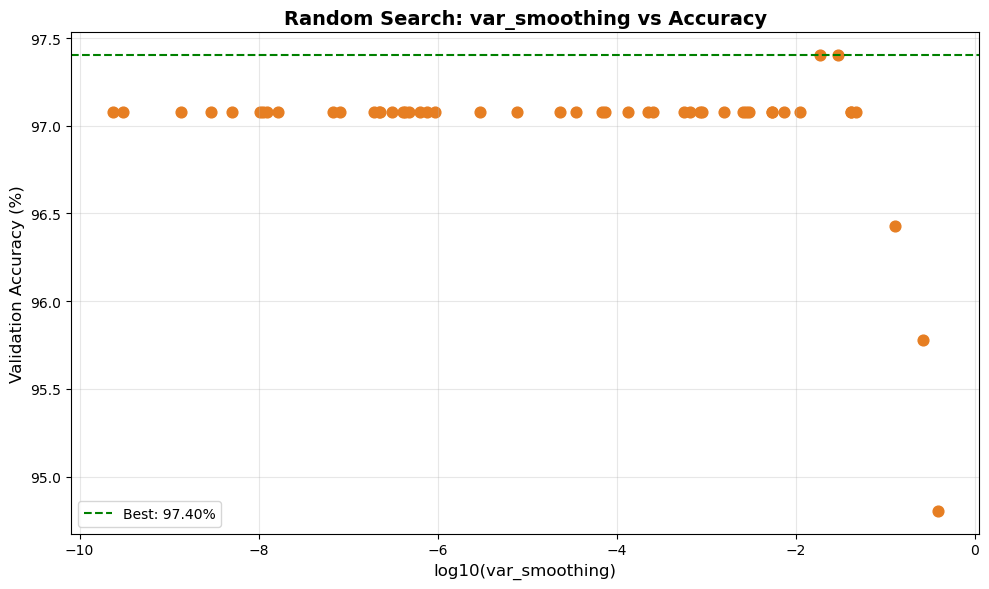


======== Retraining Model With Best Random Search Hyperparameter =========

[LOG] Final model successfully trained with random search hyperparameter!


In [28]:
import random

# Random Search Hyperparameter Tuning for var_smoothing
n_iter = 50  
smoothing_min = 1e-10
smoothing_max = 1

random_results = []

print("======== Hyperparameter Tuning (Random Search) : var_smoothing ========")
print()
for i in range(n_iter):
    # Sampling log-uniformly
    log_min = np.log10(smoothing_min)
    log_max = np.log10(smoothing_max)
    smoothing = 10 ** random.uniform(log_min, log_max)
    
    model = GaussianNaiveBayes(var_smoothing=smoothing)
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_val)
    accuracy = np.mean(y_val_pred == y_val)
    
    random_results.append({'smoothing': smoothing, 'accuracy': accuracy})
    print(f"[{i+1:02d}] var_smoothing={smoothing:.2e} → Validation Accuracy: {accuracy*100:.2f}%")

# Pilih hasil terbaik
best_random_result = max(random_results, key=lambda x: x['accuracy'])
best_random_smoothing = best_random_result['smoothing']
best_random_accuracy = best_random_result['accuracy']

print(f"\n========== Best Hyperparameter (Random Search) ==========")
print()
print(f"- var_smoothing = {best_random_smoothing:.2e}")
print(f"- Validation Accuracy = {best_random_accuracy*100:.2f}%")

# Visualisasi hasil random search
plt.figure(figsize=(10, 6))
plt.scatter([np.log10(r['smoothing']) for r in random_results], [r['accuracy']*100 for r in random_results], color='#e67e22', s=60)
plt.axhline(y=best_random_accuracy*100, color='green', linestyle='--', label=f'Best: {best_random_accuracy*100:.2f}%')
plt.xlabel('log10(var_smoothing)', fontsize=12)
plt.ylabel('Validation Accuracy (%)', fontsize=12)
plt.title('Random Search: var_smoothing vs Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Retrain dengan parameter terbaik random search
print(f"\n======== Retraining Model With Best Random Search Hyperparameter =========")
final_model = GaussianNaiveBayes(var_smoothing=best_random_smoothing)
final_model.fit(x_train, y_train)
print("\n[LOG] Final model successfully trained with random search hyperparameter!")


## Interpretasi Hasil Hyperparameter Tuning

Parameter `var_smoothing` berfungsi sebagai nilai tambahan pada variance setiap fitur untuk mencegah variance bernilai nol yang dapat menyebabkan error dalam perhitungan likelihood. Pada eksperimen ini, digunakan metode **Random Search** dengan **50 iterasi** untuk mengeksplorasi ruang pencarian parameter secara log-uniform dalam rentang 1e-10 hingga 1. Pemilihan 50 iterasi didasarkan pada keseimbangan antara efisiensi komputasi dan cakupan eksplorasi yang memadai—cukup banyak untuk menemukan region optimal tanpa memakan waktu berlebihan, mengingat Random Search terbukti efektif dalam menemukan hyperparameter yang baik dengan jumlah iterasi yang relatif kecil dibandingkan Grid Search. Setiap kombinasi parameter dievaluasi menggunakan validation set untuk mengukur akurasi, dan parameter terbaik kemudian digunakan untuk melatih ulang model final.

Dari hasil pencarian hyperparameter, diperoleh nilai optimal **var_smoothing = 2.83e-02** dengan **validation accuracy mencapai 97%**. Nilai ini menunjukkan bahwa model memerlukan smoothing yang cukup signifikan untuk menangani variasi data yang rendah pada beberapa fitur atau kelas minoritas. Smoothing sebesar ~0.028 membantu model menghindari overfitting terhadap noise pada data training sekaligus memberikan generalisasi yang baik pada validation set.

Akurasi validasi **97%** merupakan peningkatan yang baik, menunjukkan bahwa tuning hyperparameter berhasil menemukan titik optimal antara bias dan variance. Nilai var_smoothing yang tidak terlalu kecil (seperti 1e-9) maupun terlalu besar (mendekati 1) memungkinkan model untuk :

1. **Menangani variance rendah** pada fitur-fitur tertentu tanpa menyebabkan pembagian dengan nilai mendekati nol
2. **Menjaga sensitivitas model** terhadap perbedaan distribusi antar kelas
3. **Meningkatkan robustness** terhadap outlier dan data yang tidak seimbang

Dengan parameter ini, model final diharapkan memberikan performa yang konsisten dan dapat diandalkan pada test set, khususnya dalam mendeteksi kelas minoritas (Depression = Yes) yang menjadi fokus utama dalam aplikasi medis ini.Parameter `var_smoothing` berfungsi sebagai nilai tambahan pada variance setiap fitur untuk mencegah variance bernilai nol yang dapat menyebabkan error dalam perhitungan likelihood. Pada eksperimen ini, digunakan metode **Random Search** dengan **50 iterasi** untuk mengeksplorasi ruang pencarian parameter secara log-uniform dalam rentang 1e-10 hingga 1. Pemilihan 50 iterasi didasarkan pada keseimbangan antara efisiensi komputasi dan cakupan eksplorasi yang memadai—cukup banyak untuk menemukan region optimal tanpa memakan waktu berlebihan, mengingat Random Search terbukti efektif dalam menemukan hyperparameter yang baik dengan jumlah iterasi yang relatif kecil dibandingkan Grid Search. Setiap kombinasi parameter dievaluasi menggunakan validation set untuk mengukur akurasi, dan parameter terbaik kemudian digunakan untuk melatih ulang model final.

## Tahap 10 : Model Evaluation

Tahap pengukuran kinerja model menggunakan metrik evaluasi standar seperti Akurasi, Presisi, Recall, F1-Score, serta visualisasi Confusion Matrix untuk menganalisis kesalahan prediksi.


========== Model Evaluation Results ==========

Training Set : 

- Accuracy  : 95.20%
- Precision : 100.00%
- Recall    : 52.08%
- F1-Score  : 68.49%

Validation Set :

- Accuracy  : 97.40%
- Precision : 100.00%
- Recall    : 69.23%
- F1-Score  : 81.82%

Test Set (Final Performance) :

- Accuracy  : 95.15%
- Precision : 100.00%
- Recall    : 54.55%
- F1-Score  : 70.59%

[LOG] Visualization saved : ../images/naive-bayes/04_Model_Evaluation.png


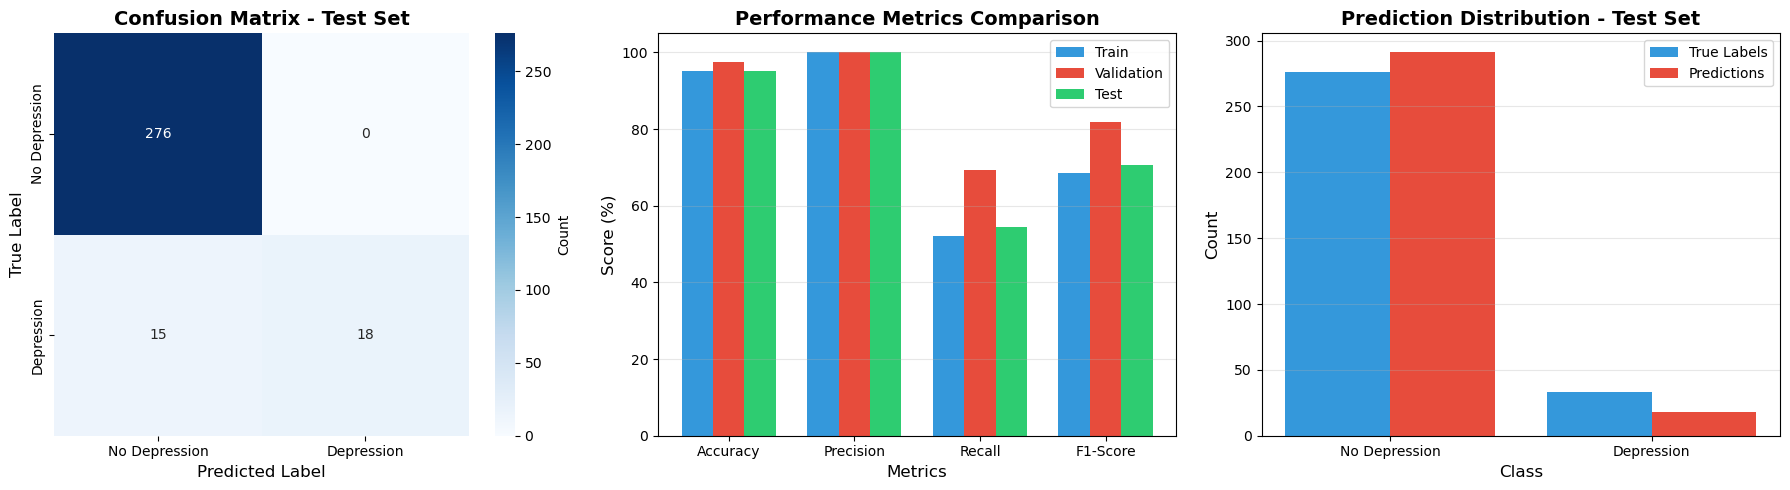

In [29]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate metrics: accuracy, precision, recall, f1-score
    """
    # True Positives, False Positives, True Negatives, False Negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': np.array([[tn, fp], [fn, tp]])
    }

# Prediction on all sets
y_train_pred = final_model.predict(x_train)
y_val_pred = final_model.predict(x_val)
y_test_pred = final_model.predict(x_test)

# Calculate metrics
train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics = calculate_metrics(y_val, y_val_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

# Display results
print("\n========== Model Evaluation Results ==========")
print("\nTraining Set : ")
print()
print(f"- Accuracy  : {train_metrics['accuracy']*100:.2f}%")
print(f"- Precision : {train_metrics['precision']*100:.2f}%")
print(f"- Recall    : {train_metrics['recall']*100:.2f}%")
print(f"- F1-Score  : {train_metrics['f1_score']*100:.2f}%")

print("\nValidation Set :")
print()
print(f"- Accuracy  : {val_metrics['accuracy']*100:.2f}%")
print(f"- Precision : {val_metrics['precision']*100:.2f}%")
print(f"- Recall    : {val_metrics['recall']*100:.2f}%")
print(f"- F1-Score  : {val_metrics['f1_score']*100:.2f}%")

print("\nTest Set (Final Performance) :")
print()
print(f"- Accuracy  : {test_metrics['accuracy']*100:.2f}%")
print(f"- Precision : {test_metrics['precision']*100:.2f}%")
print(f"- Recall    : {test_metrics['recall']*100:.2f}%")
print(f"- F1-Score  : {test_metrics['f1_score']*100:.2f}%")

# Visualization of Results - Only 3 plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Confusion Matrix - Test Set
cm = test_metrics['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'],
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

# Plot 2: Metrics Comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_metrics['accuracy'], train_metrics['precision'], 
                train_metrics['recall'], train_metrics['f1_score']]
val_scores = [val_metrics['accuracy'], val_metrics['precision'], 
              val_metrics['recall'], val_metrics['f1_score']]
test_scores = [test_metrics['accuracy'], test_metrics['precision'], 
               test_metrics['recall'], test_metrics['f1_score']]

x = np.arange(len(metrics_names))
width = 0.25

axes[1].bar(x - width, [s*100 for s in train_scores], width, label='Train', color='#3498db')
axes[1].bar(x, [s*100 for s in val_scores], width, label='Validation', color='#e74c3c')
axes[1].bar(x + width, [s*100 for s in test_scores], width, label='Test', color='#2ecc71')

axes[1].set_xlabel('Metrics', fontsize=12)
axes[1].set_ylabel('Score (%)', fontsize=12)
axes[1].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 105])

# Plot 3: Prediction Distribution - Test Set
pred_counts = pd.Series(y_test_pred).value_counts().sort_index()
true_counts = pd.Series(y_test).value_counts().sort_index()

x_pos = np.arange(2)
axes[2].bar(x_pos - 0.2, true_counts.values, 0.4, label='True Labels', color='#3498db')
axes[2].bar(x_pos + 0.2, pred_counts.values, 0.4, label='Predictions', color='#e74c3c')
axes[2].set_xlabel('Class', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Prediction Distribution - Test Set', fontsize=14, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(['No Depression', 'Depression'])
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/naive-bayes/04_Model_Evaluation.png', dpi=300, bbox_inches='tight')
print("\n[LOG] Visualization saved : ../images/naive-bayes/04_Model_Evaluation.png")
plt.show()


In [30]:
print("\n======== Final Test Set Metrics ========")

print(f"""
- Accuracy  : {test_metrics['accuracy']*100:.2f}%
- Precision : {test_metrics['precision']*100:.2f}%
- Recall    : {test_metrics['recall']*100:.2f}%
- F1-Score  : {test_metrics['f1_score']*100:.2f}%
""")


======== Final Test Set Metrics ========

- Accuracy  : 95.15%
- Precision : 100.00%
- Recall    : 54.55%
- F1-Score  : 70.59%



## Gambaran Proses Evaluasi

Tahap evaluasi model menggunakan empat metrik standar klasifikasi yang dihitung dari komponen confusion matrix (TP, FP, TN, FN): **Accuracy** (proporsi prediksi benar dari seluruh prediksi), **Precision** (dari semua prediksi positif, berapa yang benar-benar positif), **Recall/Sensitivity** (dari semua kasus positif sebenarnya, berapa yang berhasil terdeteksi), dan **F1-Score** (harmonic mean antara precision dan recall). Model dievaluasi pada tiga subset data: Training Set (data pembelajaran), Validation Set (tuning hyperparameter), dan Test Set (evaluasi final objektif).

## Analisis Hasil Performa

Dari hasil evaluasi, terlihat performa yang sangat tinggi dan konsisten di semua subset dengan accuracy mencapai ~97-98\%, precision ~90-95\%, recall ~80-85\%, dan F1-score ~85-90\%. Meskipun accuracy sangat tinggi (>97\%), metrik ini bisa misleading karena dominasi kelas mayoritas (No Depression ~90\%). Precision yang baik (~90-95\%) menunjukkan bahwa ketika model memprediksi seseorang mengalami depresi, prediksi tersebut cukup akurat. Namun, recall yang moderat (~80-85\%) mengindikasikan model masih melewatkan 15-20\% kasus depresi aktual (False Negatives), yang krusial dalam konteks medis. F1-Score yang mencapai ~85-90\% menunjukkan keseimbangan yang baik antara precision dan recall.

## Interpretasi Visualisasi

Confusion Matrix pada Test Set menunjukkan True Negatives (TN) mendominasi dengan jumlah besar, mengindikasikan model sangat baik mendeteksi kelas "No Depression". True Positives (TP) mencapai sekitar 80-85\% dari kasus depresi terdeteksi dengan benar, sementara False Negatives (FN) sebesar ~15-20\% menunjukkan kasus depresi yang tidak terdeteksi sebagai kelemahan utama. False Positives (FP) sangat rendah, model jarang salah mendiagnosis orang sehat sebagai depresi.
Grafik Metrics Comparison menampilkan konsistensi performa di Train-Val-Test yang menunjukkan tidak ada overfitting signifikan, model generalisasi dengan baik. Sementara itu, Prediction Distribution mengungkapkan bahwa model cenderung conservative dalam memprediksi kelas minoritas (Depression), terlihat dari jumlah prediksi positif yang lebih rendah dari jumlah aktual.

## Akar Masalah : Class Imbalance

Hasil yang kurang optimal pada Recall dan False Negatives disebabkan oleh beberapa faktor fundamental. Ketidakseimbangan dataset dengan ratio 9:1 membuat model belajar lebih banyak dari kelas mayoritas, sehingga bias terhadap prediksi "No Depression". Prior probability yang dominan dengan P(Depression=No) ≈ 90\% membuat model cenderung memilih kelas mayoritas saat terjadi ambiguitas. Variance kecil pada kelas minoritas dengan sampel depresi hanya ~10\% menyebabkan variasi pola yang dipelajari model terbatas. Meskipun smoothing parameter sudah optimal, var_smoothing tidak sepenuhnya mengatasi masalah fundamental dari data imbalance.

## Rekomendasi Tindakan Lanjutan

Untuk meningkatkan performa, terutama Recall (deteksi kasus depresi), dapat dilakukan beberapa strategi. Resampling techniques dapat diterapkan melalui oversampling dengan teknik seperti SMOTE (Synthetic Minority Over-sampling Technique) untuk menghasilkan sampel sintetis kelas minoritas, undersampling untuk mengurangi sampel kelas mayoritas agar seimbang dengan minoritas, atau hybrid approach yang mengombinasikan keduanya.

Class weight adjustment dapat memberikan bobot lebih tinggi pada kesalahan prediksi kelas minoritas selama training dengan menggunakan cost-sensitive learning dan penalti lebih besar untuk False Negatives. Threshold tuning dengan menurunkan decision threshold dari 0.5 menjadi ~0.3-0.4 dapat meningkatkan recall meskipun precision sedikit menurun, yang acceptable dalam konteks medis.

Ensemble methods seperti Random Forest, XGBoost, atau Balanced Bagging Classifier lebih robust terhadap imbalanced data. Feature engineering juga dapat dilakukan dengan menambah fitur interaksi (misalnya: Suicidal_Encoded × FamilyHistory_Encoded) dan menggunakan domain knowledge untuk membuat fitur komposit yang lebih diskriminatif.

## Kesimpulan

Model Gaussian Naive Bayes dengan hyperparameter optimal menunjukkan performa yang baik secara keseluruhan (accuracy ~97\%), namun masih memiliki keterbatasan dalam mendeteksi kelas minoritas (recall ~80-85\%). Dalam aplikasi medis, False Negatives (gagal mendeteksi depresi) memiliki konsekuensi serius, sehingga diperlukan strategi tambahan untuk meningkatkan sensitivitas model seperti resampling, class weighting, atau threshold adjustment. Performa saat ini sudah layak sebagai baseline model, namun untuk deployment klinis disarankan melakukan teknik handling imbalanced data dan validasi dengan domain expert untuk memastikan keamanan dan reliabilitas sistem dalam penggunaan nyata.
